In [1]:
from os.path import basename as _basename
from astropy.time import Time 
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
##gather data
#checking multiple dates
file_sa48_2014_new = "suomi_data/SA48nrt_2014_new.plot"
file_sa46_2014_new = "suomi_data/SA46nrt_2014_new.plot"
file_p014_2014_new = "suomi_data/P014nrt_2014_new.plot"
#2014
file_sa48_2014 = "suomi_data/SA48nrt_2014.plot"
file_sa46_2014 = "suomi_data/SA46nrt_2014.plot"
file_p014_2014 = "suomi_data/P014nrt_2014.plot"
#2015
file_kitt_2015 = "suomi_data/KITTnrt_2015.plot"
file_sa48_2015 = "suomi_data/SA48nrt_2015.plot"
file_sa46_2015 = "suomi_data/SA46nrt_2015.plot"
file_p014_2015 = "suomi_data/P014nrt_2015.plot"
file_azam_2015 = "suomi_data/AZAMnrt_2015.plot"
#2016
#file_kitt_2016 = "KITTnrt_2016.plot.txt"
file_sa46_2016 = "suomi_data/SA46nrt_2016.plot"
file_p014_2016 = "suomi_data/P014nrt_2016.plot"

In [3]:
#group data by year
all_data_2014_new = [file_sa48_2014_new, file_sa46_2014_new, file_p014_2014_new]
all_data_2014 = [file_sa48_2014, file_sa46_2014, file_p014_2014]
all_data_2015 = [file_kitt_2015, file_sa48_2015, file_sa46_2015, file_p014_2015, file_azam_2015]
#all_data_2016= (file_kitt_2016, file_sa46_2016, file_p014_2016)
all_data_2016= [file_sa46_2016, file_p014_2016]


In [4]:
def get_data(path):
    """Returns SuomiNet data from a file path as a numpy array

    Expects data files from http://www.suominet.ucar.edu/data.html
    under the "Specific station - All year hourly" row. The returned
    array has column names 'date', 'pwv', 'pres', 'temp', and 'hum'.
    
    Args:
        path (str): File path to be read

    Returns:
        data (numpy.ndarray): Numpy array with data from file
    """
    
    data = np.genfromtxt(path, usecols=(1,2,7,8,9),
                         names=('date', 'pwv', 'pres', 'temp', 'hum'),
                         dtype=((np.str_, 16), float, float, float, float))

    data = np.unique(data) # Remove duplicate entries
    return data


In [5]:
def get_date_list(*data_arrays):
    """Construct a sorted list of unique dates from a collection of arrays

    Given multiple numpy arrays, create a sorted list of the unique dates found
    in all of the arrays. Expects arrays returned by 'get_data'.
    
    Args:
        data_arrays (numpy.ndarray): Numpy array returned by 'get_data'
    
    Returns:
        mjd (list): Sorted list of unique datetimes expressed in MJD
    """

    datetimes = np.concatenate([array['date'] for array in data_arrays])
    # [array['date'] for array in data_arrays] is a list of arrays each having
    # only the datetime info; np.concatenate combines these into a single array
    
    unique_datetimes = np.unique(datetimes)
    mjd = sorted([Time(t, format='isot').mjd for t in unique_datetimes])
    
    return mjd


In [6]:
def pad_data(dates, data):
    """Pad and mask an array of PWV values to match a list of dates

    Given an array of PWV measurments and their corresponding datetimes, pad
    the array so that there is an entry for every datetime in a given list.
    Expects the first argument to be a return from 'get_dates' and the second
    second argument to be from 'get_data'.
    
    Args:
        dates (list): A list of unique datetimes returned by 'get_dates'
        data  (numpy.ndarray): An array returned by 'get_data'
    
    Returns:
        padded_data (list): A padded data array
    """

    mask, pwv_list = [], []

    # Get the times for the current site and express them in mjd format
    times_mjd = [Time(elt[0], format='isot').mjd for elt in data] 

    for date in dates:
        if date in times_mjd:
            time = Time(date, format='mjd').isot[:-7]
            ind = np.where(data['date'] == time)
            pwv = data[ind]['pwv']

            if len(pwv) == 1 and pwv > 0: # Eliminate cases with multiple values
                pwv_list.append(np.asscalar(pwv))
                mask.append(0)
                continue

        mask.append(1)
        pwv_list.append(1) # Filler value

    padded_data = np.ma.array(data=pwv_list, mask=mask)
    return padded_data


In [7]:
def model_pwv(kitt_data, other_data):

    modeled_data = []
    print('PWV Fit Functions (Check fit parameters make sense):')
    for array in other_data:
        ind = np.logical_and(np.invert(kitt_data.mask), np.invert(array.mask))
        
        kitt_pwv = np.extract(kitt_data.data, ind)
        other_pwv = np.extract(array.data, ind)
        plt.plot(other_pwv, kitt_pwv)
        plt.show()
        
        func_parameters = np.polyfit(other_pwv, kitt_pwv, 1)
        print(func_parameters)
        vfunc = np.vectorize(np.poly1d(func_parameters))
        
        modeled_pwv = np.ma.array(data=vfunc(array.data), mask=array.mask)
        modeled_data.append(modeled_pwv)
        
    return np.ma.mean(modeled_data, 0)



In [8]:
def combine_data(files):
    """Combine the data from a list of file paths into a single masked array
    """

    if not isinstance(files, list) or not files:
        raise Exception('Argument must be a non-empty list')

    # Seperate the kitt data from other data
    try:
        # Try to find the file path pertaining to the Kitt Peak reciever
        print('Seperating File Paths')
        kitt_path = next(f for f in files if _basename(f)[:4].upper()=='KITT')
        other_paths = list(set(files) - set([kitt_path]))
        
        print('All Files: ', files, '\n')
        print('Kitt Path (Check for correct path): ', kitt_path, '\n')
        print('Other Paths (Check for correct paths): ', other_paths, '\n', flush=True)
        
        # Read data from file paths
        print('Reading Data from file')
        kitt_data = get_data(kitt_path)
        other_data = [get_data(f) for f in other_paths]
        
        print('Kitt Data Length (should be 13728 for 2015): ', len(kitt_data))
        print('Other Data (Check values and dtypes):\n', other_data, '\n', flush=True)
        
        # Get list of unique dates
        dates = get_date_list(kitt_data, *other_data)

        # Pad the KITT data - return it if there is no other data
        print('Padding Kitt Data')
        kitt_padded = pad_data(dates, kitt_data)
        if not other_data: return kitt_padded
        
        print('Kitt Padded Data and Mask:')
        print(kitt_padded.data, kitt_padded.mask, '\n', flush=True)
        
        # Pad the other data and combine it into a single array
        print('Padding Other Data')
        other_padded = [pad_data(dates, site) for site in other_data]
        print('Modeling PWV from other sites', flush=True)
        other_modeled = model_pwv(kitt_padded, other_padded)
        
        print('\nModeled PWV:')
        print(other_modeled.data, other_modeled.mask, '\n', flush=True)
        
        # Combine the arrays
        print('Combining Arrays')
        data = np.where(kitt_padded.mask, other_modeled.data, kitt_padded.data)
        mask = np.where(kitt_padded.mask, other_modeled.mask, kitt_padded.mask)
        combined_array = np.ma.masked_array(data=data, mask=mask)
        
        print('Kitt, modeled, and combined data (Check for proper replacement):')
        print(kitt_padded.data[0:9])
        print(other_modeled.data[0:9])
        print(combined_array.data[0:9], '\n')
        
        print(kitt_padded.data[len(kitt_padded.data)-10:])
        print(other_modeled.data[len(other_modeled.data)-10:])
        print(combined_array.data[len(combined_array.data)-10:])
        
        return dates, combined_array

    except StopIteration:
        # If there is no data file for the Kitt peak reciever
        other_data = [get_data(f) for f in files]
        dates = get_date_list(*other_data)
        padded_list = [pad_data(dates, site) for site in other_data]
        other_padded = np.ma.mean(padded_list, 0)
        return dates, other_padded


In [9]:
from datetime import datetime

def test(files):
    start=datetime.now()
    x = combine_data(files)[1]
    time = datetime.now()-start

    total = len(x.data)
    m_neg_vals = len([elt for elt in  x.data if elt<0])
    neg_vals = len([elt for i, elt in enumerate(x.data) if elt<0 and not x.mask[i]])
    m_zeros = len([elt for elt in  x.data if elt==0])
    zeros = len([elt for i, elt in enumerate(x.data) if elt==0 and not x.mask[i]])
    masked = len([y for y in list(x.mask) if y])

    print('{0} files combined in {1}'.format(len(all_data_2015), time))
    print('Total PWV values: {0}'.format(total))
    print('Negative PWV values {0} ({1}%)'.format(m_neg_vals, m_neg_vals/total*100))
    print('Unmasked negative PWV values {0} ({1}%)'.format(neg_vals, neg_vals/total*100))
    print('PWV values equal to zero:  {0} ({1}%)'.format(m_zeros, m_zeros/total*100))
    print('Unmasked PWV values equal to zero:  {0} ({1}%)'.format(zeros, zeros/total*100))
    print('Masked PWV values:  {0} ({1}%)\n'.format(masked, masked/total*100))


Seperating File Paths
All Files:  ['suomi_data/KITTnrt_2015.plot', 'suomi_data/SA48nrt_2015.plot', 'suomi_data/SA46nrt_2015.plot', 'suomi_data/P014nrt_2015.plot', 'suomi_data/AZAMnrt_2015.plot'] 

Kitt Path (Check for correct path):  suomi_data/KITTnrt_2015.plot 

Other Paths (Check for correct paths):  ['suomi_data/P014nrt_2015.plot', 'suomi_data/SA46nrt_2015.plot', 'suomi_data/SA48nrt_2015.plot', 'suomi_data/AZAMnrt_2015.plot'] 

Reading Data from file
Kitt Data Length (should be 13728 for 2015):  13728
Other Data (Check values and dtypes):
 [array([('2015-01-02T04:15', 7.2, 890.6, -1.3, 88.9),
       ('2015-01-02T04:45', 6.6, 890.6, -1.3, 87.6),
       ('2015-01-02T08:15', 7.0, 889.8, -2.4, 86.9), ...,
       ('2015-12-31T22:45', 4.7, 891.1, 13.2, 28.5),
       ('2015-12-31T23:15', 4.9, 891.1, 12.5, 30.5),
       ('2015-12-31T23:45', 5.3, 891.2, 11.7, 32.4)], 
      dtype=[('date', '<U16'), ('pwv', '<f8'), ('pres', '<f8'), ('temp', '<f8'), ('hum', '<f8')]), array([('2015-01-01T09:15

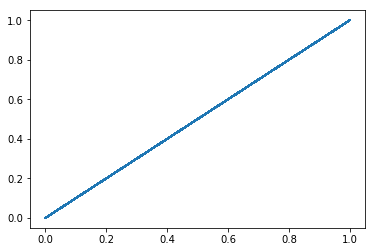

[  1.00000000e+00   3.27188620e-16]


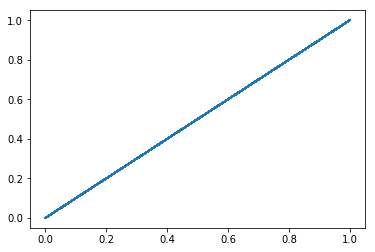

[  1.00000000e+00   1.63594310e-16]


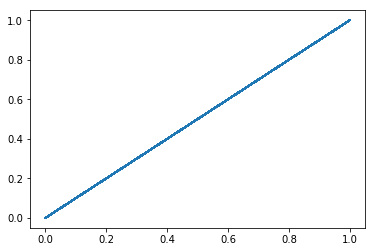

[  1.00000000e+00   5.45314366e-17]


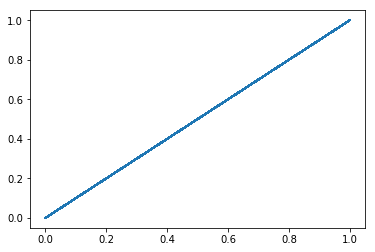

[  1.00000000e+00  -5.45314366e-17]

Modeled PWV:
[ 7.35        6.85        0.         ...,  5.63333333  5.83333333
  5.93333333] [False False  True ..., False False False] 

Combining Arrays
Kitt, modeled, and combined data (Check for proper replacement):
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.]
[ 7.35  6.85  0.    0.    6.85  7.55  7.    6.7   7.35]
[ 7.35  6.85  0.    0.    6.85  7.55  7.    6.7   7.35] 

[ 0.8  1.7  1.2  0.9  1.2  1.4  1.7  1.4  1.2  0.7]
[ 4.93333333  4.8         4.8         4.93333333  5.13333333  5.2         5.5
  5.63333333  5.83333333  5.93333333]
[ 0.8  1.7  1.2  0.9  1.2  1.4  1.7  1.4  1.2  0.7]
5 files combined in 0:00:44.706855
Total PWV values: 16978
Negative PWV values 0 (0.0%)
Unmasked negative PWV values 0 (0.0%)
PWV values equal to zero:  577 (3.39851572623395%)
Unmasked PWV values equal to zero:  0 (0.0%)
Masked PWV values:  577 (3.39851572623395%)



In [10]:
test(all_data_2015)